# **Introduction**

This notebook covers the data preprocessing and Exploratory Data Analysis of the news train dataset. 
The outline of the functions perfomed in the notebook as follows

- Data preprocessing - checking for null values and preprocessing the dataset.
- Exploratory Data Analysis - covers the data distribution, topic modelling and Hypothesis Testing.
- Finally, the preprocessed file is saved for later use in modelling.

In [158]:
# Importing required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
import nltk
import re

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


In [160]:
# Load train dataset to train dataframes

train_df = pd.read_csv('data/news/train.csv',encoding='UTF-8')

In [161]:
train_df.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# **Data Preprocessing**

- Check for null values and appropriately handle the null values
- Concatenate the applicable columns
- Remove unwanted and redundant columns
- Apply stopword removal and stemming

In [163]:
# Number of rows in the train dataframe
train_df.shape[0]

20800

The positive and negative classes are equally distributed and there is no imbalance found.

In [164]:
# Counts of classes in the train dataframe
train_df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

The Title, Author and Text columns seems to have null values.
- The "author" column is redundant as it is not used for modeling and can be removed.
- The "text" column is critical as that holds the news article. If empty the rows need to be removed as its not viable to fill in the news article.
- The "title" column can be concatenated with the "text" column so if the "title" is empty its ok as long as the "text" column has values.

Text(0, 0.5, 'Count')

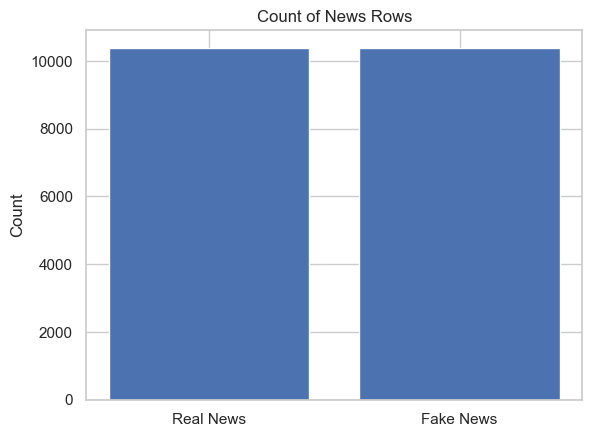

In [214]:
plt.bar(['Real News', 'Fake News'], [len(train_df[train_df['label']==0]), len(train_df[train_df['label']==1])])
plt.title('Count of News Rows')
plt.ylabel('Count')

In [165]:
# check for any NaN values in the dataset
train_df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [166]:
# Remove columns 'author' and 'id'
train_df.drop(['author', 'id'], axis = 1, inplace=True)

In [167]:
train_df.columns

Index(['title', 'text', 'label'], dtype='object')

In [168]:
# Remove rows that are null in text
train_df = train_df.dropna(subset=['text'])

In [169]:
# check for any NaN values in the dataset
train_df.isna().sum()

title    558
text       0
label      0
dtype: int64

Removing text column null rows, we are left with nulls in title. Lets concatenate title and text to form the columns news.

In [170]:
train_df.info() # Before concatenating the columns check for column datatypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 20799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20203 non-null  object
 1   text    20761 non-null  object
 2   label   20761 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 648.8+ KB


In [171]:
# combine title and text together
train_df['news'] = train_df['title'].fillna('') + ' ' + train_df['text']
train_df.head()

,title,text,label,news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [172]:
train_df['news'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House In

In [173]:
# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\email\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [174]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [175]:
# Function to remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, max_len=25):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

In [176]:
# Apply the function to the dataframe
train_df['clean'] = train_df['news'].apply(preprocess)

In [209]:
# Remove rows that are empty 
train_df = train_df[train_df['clean'].apply(lambda x: len(x) > 0)]

In [210]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20758 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         20203 non-null  object
 1   text          20758 non-null  object
 2   label         20758 non-null  int64 
 3   news          20758 non-null  object
 4   clean         20758 non-null  object
 5   clean_joined  20758 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.1+ MB


In [178]:
train_df.head()

,title,text,label,news,clean
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,"[house, aide, comey, letter, jason, chaffetz, ..."
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...","[flynn, hillary, clinton, woman, campus, breit..."
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...,"[truth, fired, truth, fired, october, tension,..."
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,"[civilians, killed, single, airstrike, identif..."
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,"[iranian, woman, jailed, fictional, unpublishe..."


In [179]:
# join the words into a string
train_df['clean_joined'] = train_df['clean'].apply(lambda x: " ".join(x))

In [180]:
train_df.head()

,title,text,label,news,clean,clean_joined
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,"[house, aide, comey, letter, jason, chaffetz, ...",house aide comey letter jason chaffetz tweeted...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...","[flynn, hillary, clinton, woman, campus, breit...",flynn hillary clinton woman campus breitbart f...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...,"[truth, fired, truth, fired, october, tension,...",truth fired truth fired october tension intell...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,"[civilians, killed, single, airstrike, identif...",civilians killed single airstrike identified v...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,"[iranian, woman, jailed, fictional, unpublishe...",iranian woman jailed fictional unpublished sto...


In [181]:
real_news = train_df[train_df['label'] == 0].copy()
fake_news = train_df[train_df['label'] == 1].copy()

In [182]:
real_text = ' '.join(real_news['clean_joined'])
fake_text = ' '.join(fake_news['clean_joined'])

At the end of the preprocessing step, the clean processed news articles are written to the clean_joined column. The next steps can no use the clean_joined column going forward.

# *Exploratory Data Analysis*

## **Preliminary Analysis**: 
An initial exploration to ascertain the balance between real and fake news articles revealed a well-balanced dataset, mitigating the risk of potential model bias towards a specific class. A more in-depth exploration into textual characteristics, such as average and unique word count in both real and fake news articles, was undertaken. It surfaced that real news articles tended to have a higher word count on average and showcased a greater number of unique words. This suggests that fake news articles might adhere to certain templates or repeat set phrases, resulting in lower unique word counts.

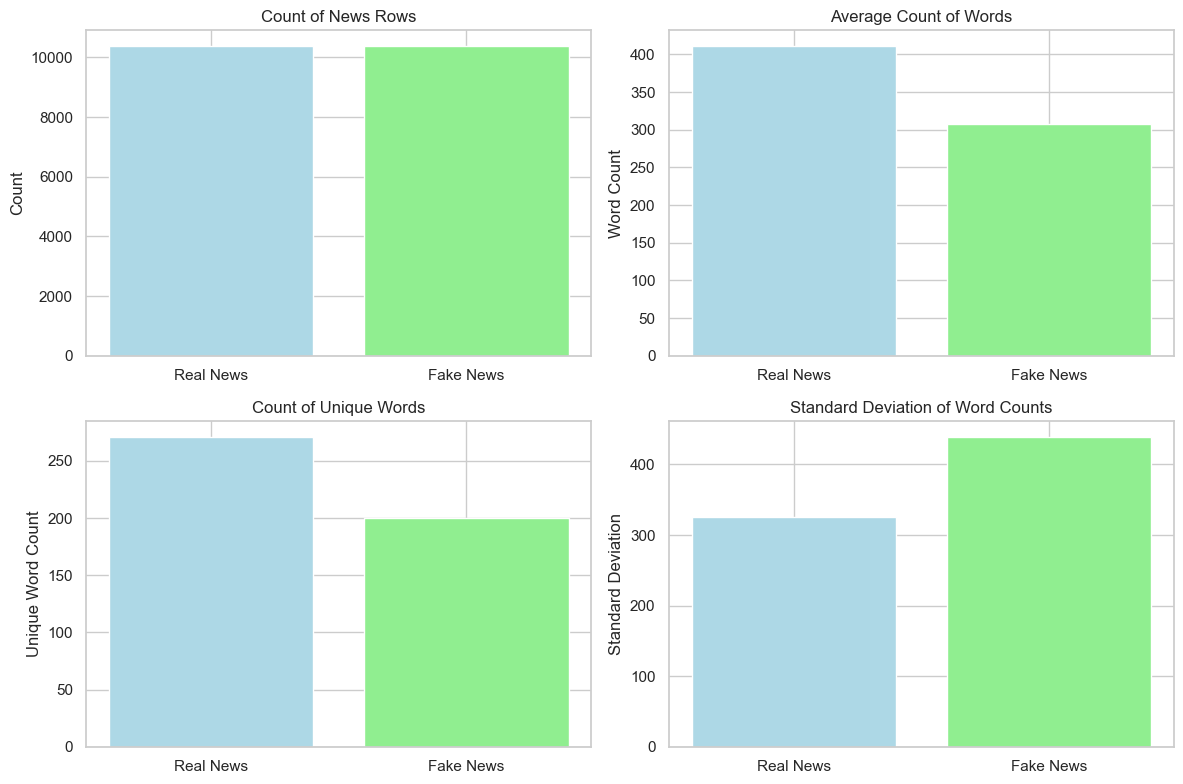

In [219]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the counts for real and fake news
real_count_news = len(real_news)
fake_count_news = len(fake_news)

real_word_count = real_news['clean_joined'].str.split().apply(len)
fake_word_count = fake_news['clean_joined'].str.split().apply(len)

real_unique_word_count = real_news['clean_joined'].str.split().apply(set).apply(len)
fake_unique_word_count = fake_news['clean_joined'].str.split().apply(set).apply(len)

# Create the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Colors for the bars
colors = ['lightblue', 'lightgreen']

# Plot count of news rows
axes[0, 0].bar(['Real News', 'Fake News'], [real_count_news, fake_count_news], color=colors)
axes[0, 0].set_title('Count of News Rows')
axes[0, 0].set_ylabel('Count')

# Plot count of words
axes[0, 1].bar(['Real News', 'Fake News'], [real_word_count.mean(), fake_word_count.mean()], color=colors)
axes[0, 1].set_title('Average Count of Words')
axes[0, 1].set_ylabel('Word Count')

# Plot count of unique words
axes[1, 0].bar(['Real News', 'Fake News'], [real_unique_word_count.mean(), fake_unique_word_count.mean()], color=colors)
axes[1, 0].set_title('Count of Unique Words')
axes[1, 0].set_ylabel('Unique Word Count')

# Calculate and plot standard deviation of word counts
word_count_std = [real_word_count.std(), fake_word_count.std()]
axes[1, 1].bar(['Real News', 'Fake News'], word_count_std, color=colors)
axes[1, 1].set_title('Standard Deviation of Word Counts')
axes[1, 1].set_ylabel('Standard Deviation')

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplot
plt.show()


## **Data Distribution**: 
Our exploration also indicated that the fake news articles demonstrated a higher standard deviation in average word count, suggesting a lack of consistency in their length. Upon comparing the distribution of word counts across real and fake news, both types showed a right-skewed distribution. However, the fake news category had more outliers in word count, with the bulk of real news falling between 0 and 4000 words.

In [184]:
# Add count of words column to real_news DataFrame
real_news['word_count'] = real_news['clean_joined'].str.split().apply(len)

# Add count of words column to fake_news DataFrame
fake_news['word_count'] = fake_news['clean_joined'].str.split().apply(len)

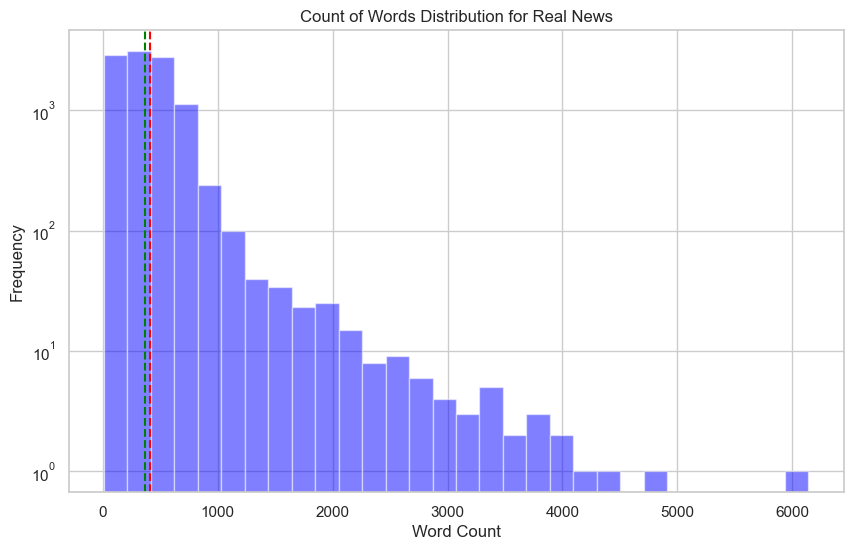

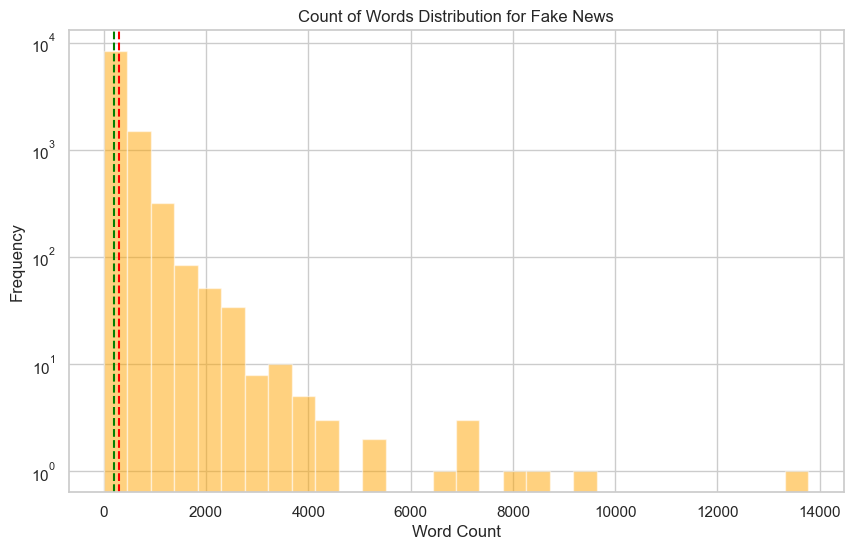

In [185]:
# Plot count of words distribution for real news
plt.figure(figsize=(10, 6))
plt.hist(real_news['word_count'], bins=30, color='blue', alpha=0.5)
plt.axvline(real_news['word_count'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(np.median(real_news['word_count']), color='green', linestyle='--', label='Median')
plt.title('Count of Words Distribution for Real News')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

# Plot count of words distribution for fake news
plt.figure(figsize=(10, 6))
plt.hist(fake_news['word_count'], bins=30, color='orange', alpha=0.5)
plt.axvline(fake_news['word_count'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(np.median(fake_news['word_count']), color='green', linestyle='--', label='Median')
plt.title('Count of Words Distribution for Fake News')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

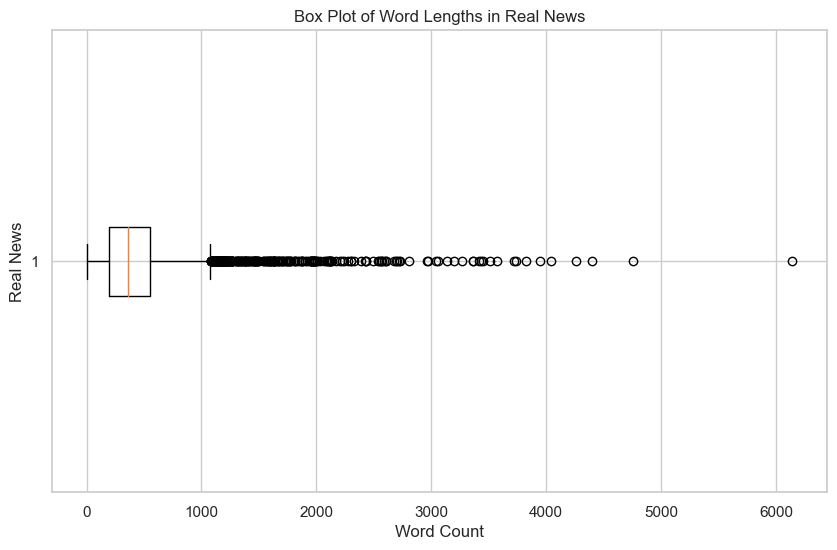

In [186]:
# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(real_news['word_count'], vert=False)
plt.title('Box Plot of Word Lengths in Real News')
plt.xlabel('Word Count')
plt.ylabel('Real News')
plt.show()

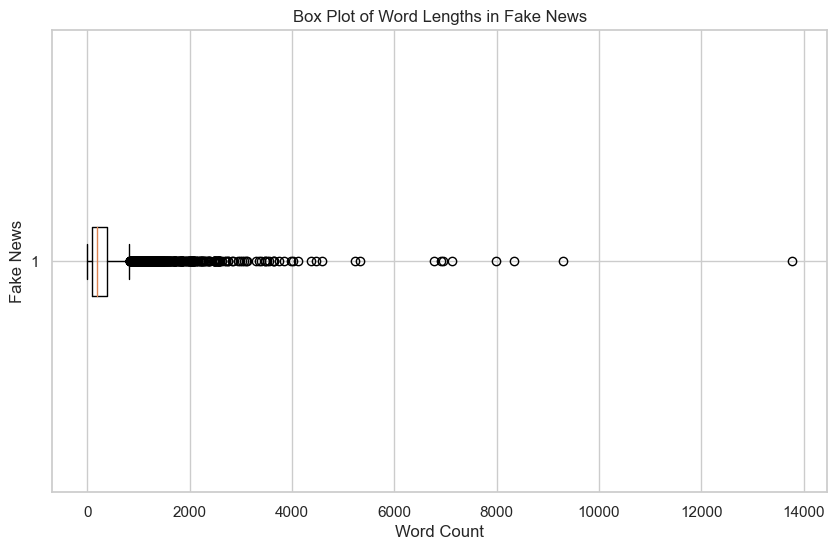

In [187]:
# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(fake_news['word_count'], vert=False)
plt.title('Box Plot of Word Lengths in Fake News')
plt.xlabel('Word Count')
plt.ylabel('Fake News')
plt.show()

## **Word Cloud**: 
A word cloud analysis shows that common words are frequently used in both Real and Fake datasets.

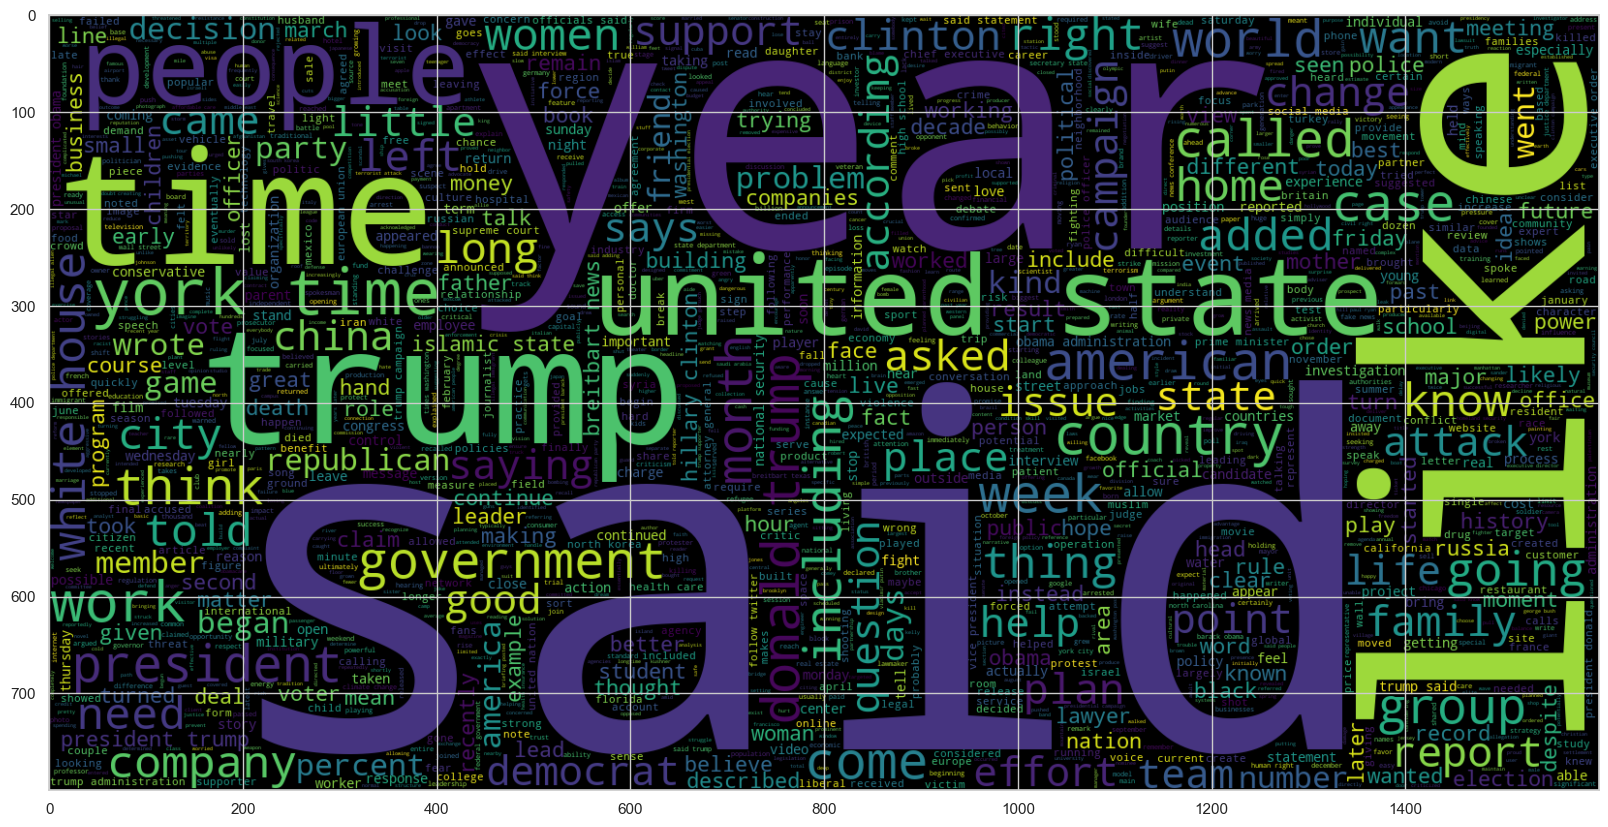

In [188]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(real_text)
plt.imshow(wc, interpolation = 'bilinear')

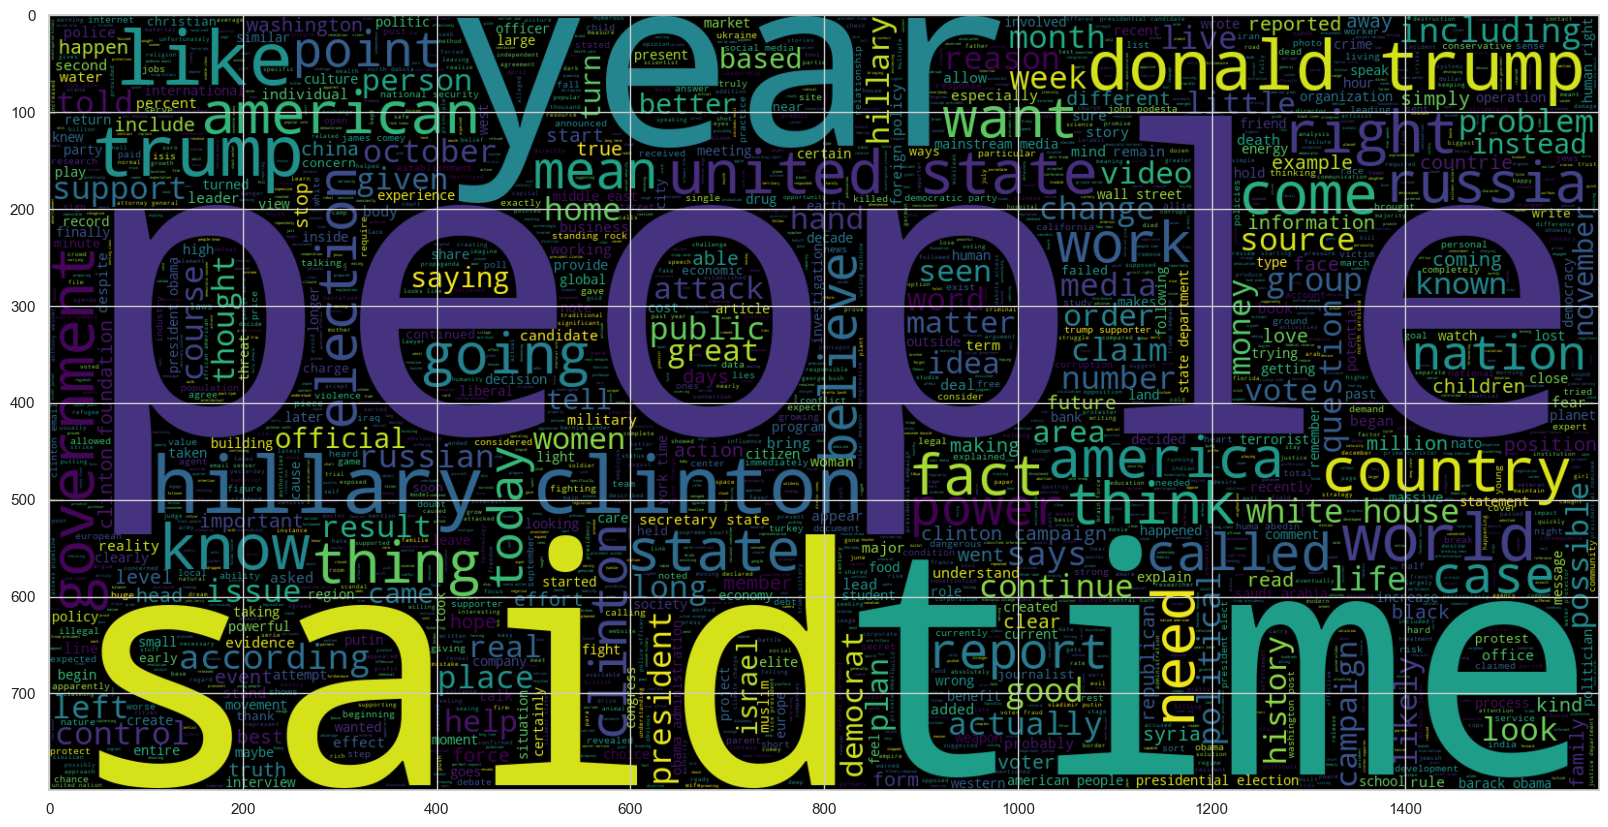

In [189]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(fake_text)
plt.imshow(wc, interpolation = 'bilinear')

## **Word Frequency Analysis**:

A word frequency analysis of top 20 words from both Real and Fake News datasets were performed. The frequency analysis shows that there are common words that shows in the first 20 words in both datasets. The frequency distribution looks has similar.

In [190]:
real_freq_dist = nltk.FreqDist(real_text.split())
fake_freq_dist = nltk.FreqDist(fake_text.split())

In [191]:
top_real_words = real_freq_dist.most_common(20)
top_fake_words = fake_freq_dist.most_common(20)

In [192]:
print(f"The top 20 real news words: {top_real_words}")

The top 20 real news words: [('said', 68223), ('trump', 38389), ('people', 20037), ('president', 17054), ('like', 16102), ('york', 12903), ('times', 12544), ('time', 11965), ('state', 11710), ('years', 11492), ('states', 11091), ('year', 10293), ('united', 10220), ('news', 9636), ('american', 9205), ('government', 8720), ('house', 8569), ('clinton', 8436), ('obama', 7849), ('country', 7454)]


In [193]:
print(f"The top 20 fake news words: {top_fake_words}")

The top 20 fake news words: [('trump', 21607), ('clinton', 20181), ('people', 16739), ('hillary', 13810), ('said', 11912), ('like', 10422), ('world', 9463), ('time', 9345), ('state', 9032), ('election', 8741), ('president', 8673), ('government', 8242), ('obama', 7831), ('american', 7110), ('russia', 7088), ('media', 6703), ('states', 6641), ('years', 6562), ('know', 6000), ('campaign', 6000)]


In [194]:
real_words, real_word_counts = zip(*top_real_words)
fake_words, fake_word_counts = zip(*top_fake_words)


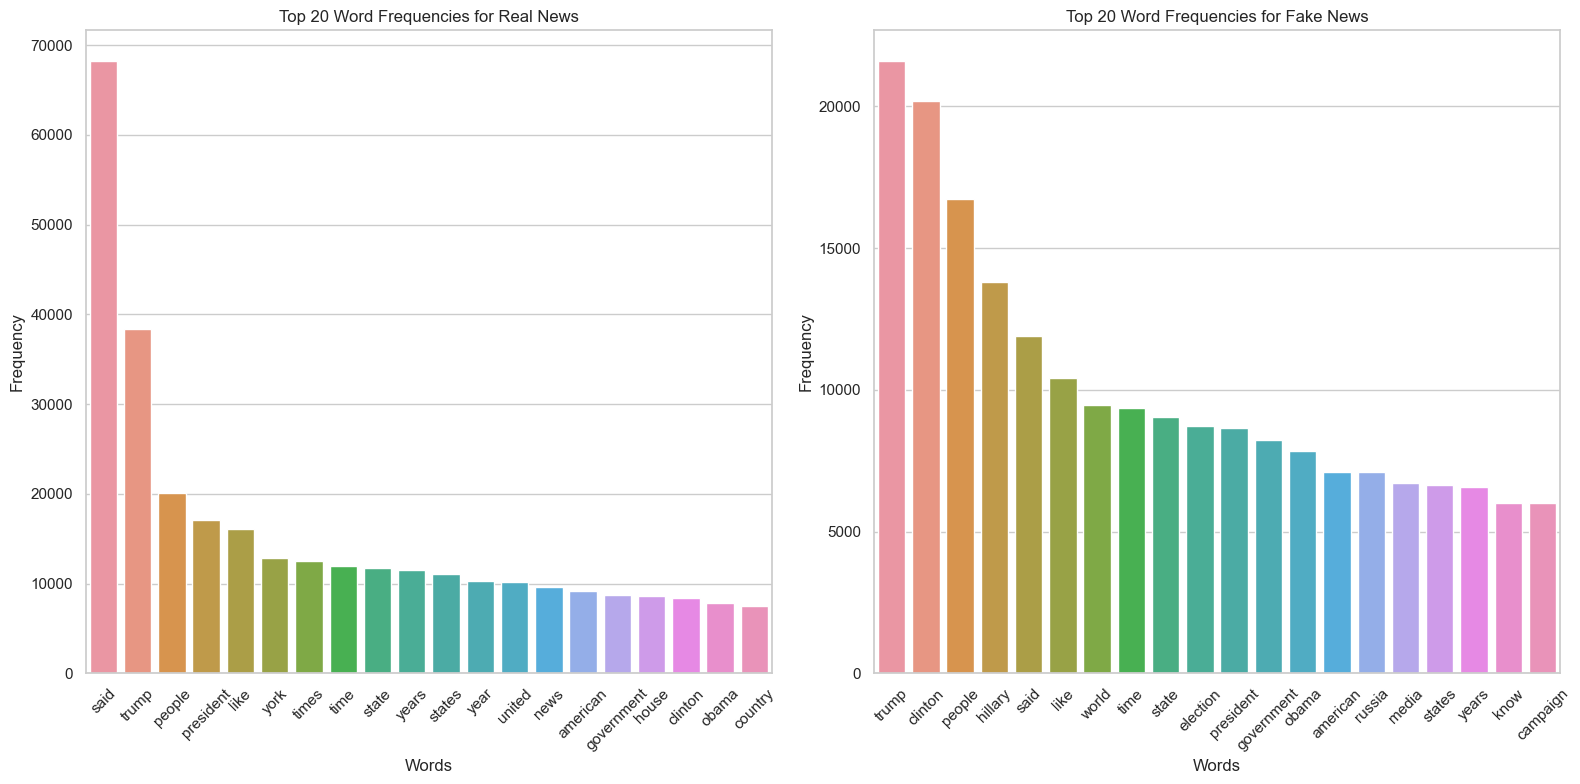

In [195]:
# Create a DataFrame for real news data
real_data = pd.DataFrame({'Words': real_words, 'Frequency': real_word_counts, 'Class': 'Real'})

# Create a DataFrame for fake news data
fake_data = pd.DataFrame({'Words': fake_words, 'Frequency': fake_word_counts, 'Class': 'Fake'})

# Concatenate the DataFrames
#data = pd.concat([real_data, fake_data])

# Plot the histograms using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

# Plot for real news
plt.subplot(1, 2, 1)
sns.barplot(x='Words', y='Frequency', data=real_data)
plt.title('Top 20 Word Frequencies for Real News')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Plot for fake news
plt.subplot(1, 2, 2)
sns.barplot(x='Words', y='Frequency', data=fake_data)
plt.title('Top 20 Word Frequencies for Fake News')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


To compare the usage of top 20 words in real news, a frequency plot was performed. The analysis shows the top 20 words in real news were also used frequently in Fake news. 

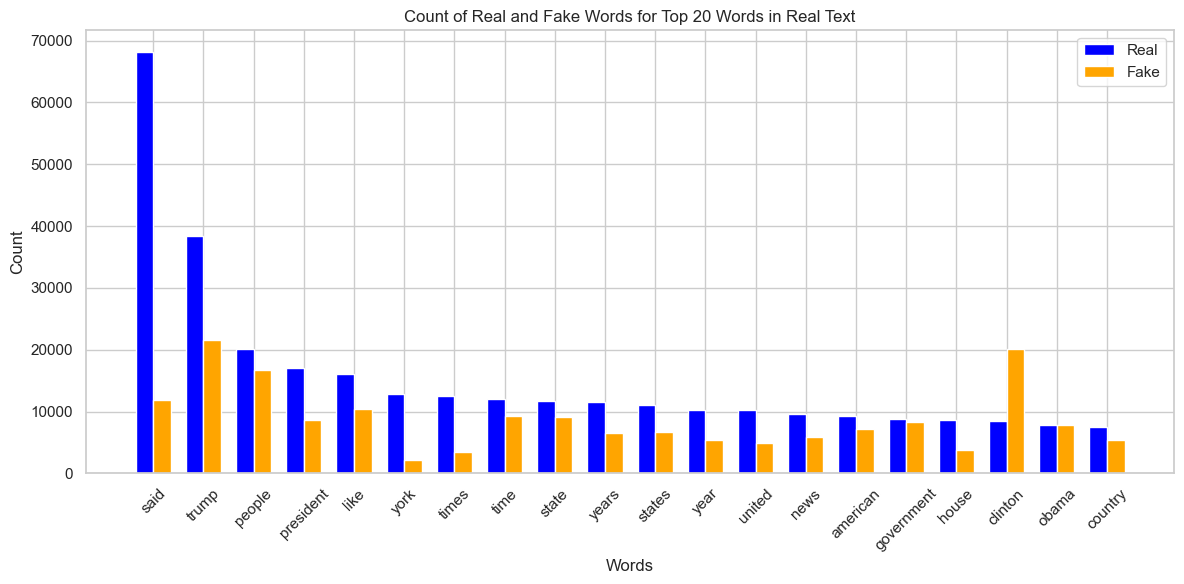

In [196]:
# Get the counts for each word in the real and fake news
real_counts = [real_freq_dist[word] for word in real_words]
fake_counts = [fake_freq_dist[word] for word in real_words]

# Create a DataFrame for the counts
data = pd.DataFrame({'Words': real_words, 'Real Counts': real_counts, 'Fake Counts': fake_counts})

# Set the width of each bar
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(real_words))
r2 = [x + bar_width for x in r1]

# Plot the adjacent bar plots
plt.figure(figsize=(12, 6))
plt.bar(r1, data['Real Counts'], color='blue', width=bar_width, label='Real')
plt.bar(r2, data['Fake Counts'], color='orange', width=bar_width, label='Fake')

# Add x-axis labels, y-axis label, and title
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Count of Real and Fake Words for Top 20 Words in Real Text')

# Customize the x-axis tick labels
plt.xticks([r + bar_width/2 for r in range(len(real_words))], real_words, rotation=45)

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()


## Topic Modeling

To uncover underlying themes within our datasets, we used topic modeling, revealing that the dominant themes across both real and fake news revolved around US Presidential Elections and US Politics. Such patterns and trends could prove invaluable when creating additional features for our classification models.

In [197]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Create a list of real news documents
real_documents = real_news['clean_joined'].tolist()

# Create a list of fake news documents
fake_documents = fake_news['clean_joined'].tolist()

# Tokenize the documents
real_tokenized_documents = [gensim.utils.simple_preprocess(doc) for doc in real_documents]
fake_tokenized_documents = [gensim.utils.simple_preprocess(doc) for doc in fake_documents]

# Create a dictionary for the real news documents
real_dictionary = corpora.Dictionary(real_tokenized_documents)

# Create a dictionary for the fake news documents
fake_dictionary = corpora.Dictionary(fake_tokenized_documents)

# Create a corpus (bag of words representation) for the real news documents
real_corpus = [real_dictionary.doc2bow(doc) for doc in real_tokenized_documents]

# Create a corpus (bag of words representation) for the fake news documents
fake_corpus = [fake_dictionary.doc2bow(doc) for doc in fake_tokenized_documents]

# Perform topic modeling on the real news corpus
num_topics = 5  # Define the number of topics to be extracted
real_lda_model = LdaModel(real_corpus, num_topics=num_topics, id2word=real_dictionary, passes=10)

# Perform topic modeling on the fake news corpus
fake_lda_model = LdaModel(fake_corpus, num_topics=num_topics, id2word=fake_dictionary, passes=10)

In [198]:
# Print the topics for real news
print("Topics for Real News:")
real_lda_model.print_topics(num_words=15)

Topics for Real News:


[(0,
  '0.015*"said" + 0.006*"states" + 0.005*"united" + 0.005*"government" + 0.005*"federal" + 0.004*"court" + 0.004*"state" + 0.004*"trump" + 0.004*"president" + 0.004*"administration" + 0.004*"company" + 0.004*"officials" + 0.004*"percent" + 0.003*"china" + 0.003*"department"'),
 (1,
  '0.009*"said" + 0.006*"like" + 0.004*"times" + 0.004*"time" + 0.004*"year" + 0.003*"team" + 0.003*"game" + 0.003*"york" + 0.003*"best" + 0.003*"years" + 0.003*"world" + 0.003*"people" + 0.003*"twitter" + 0.002*"news" + 0.002*"media"'),
 (2,
  '0.022*"said" + 0.011*"police" + 0.006*"state" + 0.005*"people" + 0.004*"attack" + 0.004*"islamic" + 0.004*"officials" + 0.004*"officers" + 0.004*"city" + 0.003*"government" + 0.003*"killed" + 0.003*"united" + 0.003*"military" + 0.003*"told" + 0.003*"group"'),
 (3,
  '0.035*"trump" + 0.016*"said" + 0.012*"president" + 0.008*"clinton" + 0.006*"campaign" + 0.006*"house" + 0.006*"people" + 0.005*"obama" + 0.005*"republican" + 0.005*"white" + 0.005*"party" + 0.005*"d

Real News Topics
- Topic 0: Government and Politics
- Topic 1: Media and Entertainment
- Topic 2: Law Enforcement and Security
- Topic 3: U.S. President and Elections
- Topic 4: Lifestyle and Society

In [199]:
# Print the topics for fake news
print("Topics for Fake News:")
fake_lda_model.print_topics(num_words=15)

Topics for Fake News:


[(0,
  '0.006*"people" + 0.006*"world" + 0.006*"government" + 0.004*"police" + 0.004*"russia" + 0.004*"state" + 0.004*"states" + 0.004*"american" + 0.003*"economic" + 0.003*"united" + 0.003*"political" + 0.003*"country" + 0.003*"china" + 0.003*"power" + 0.003*"global"'),
 (1,
  '0.006*"people" + 0.005*"like" + 0.004*"time" + 0.004*"world" + 0.003*"life" + 0.003*"years" + 0.003*"health" + 0.003*"year" + 0.003*"know" + 0.002*"water" + 0.002*"said" + 0.002*"good" + 0.002*"children" + 0.002*"need" + 0.002*"think"'),
 (2,
  '0.009*"syria" + 0.009*"russia" + 0.006*"russian" + 0.006*"military" + 0.005*"said" + 0.005*"israel" + 0.005*"syrian" + 0.005*"government" + 0.004*"forces" + 0.004*"saudi" + 0.004*"iraq" + 0.003*"isis" + 0.003*"world" + 0.003*"iran" + 0.003*"people"'),
 (3,
  '0.019*"trump" + 0.017*"clinton" + 0.011*"hillary" + 0.008*"election" + 0.006*"president" + 0.006*"obama" + 0.005*"said" + 0.005*"campaign" + 0.005*"people" + 0.005*"donald" + 0.004*"state" + 0.004*"media" + 0.004*"

Fake News Topics

- Topic 0: Global Politics
- Topic 1: Lifestyle
- Topic 2: International Conflicts
- Topic 3: U.S. Politics
- Topic 4: Foreign Language Content

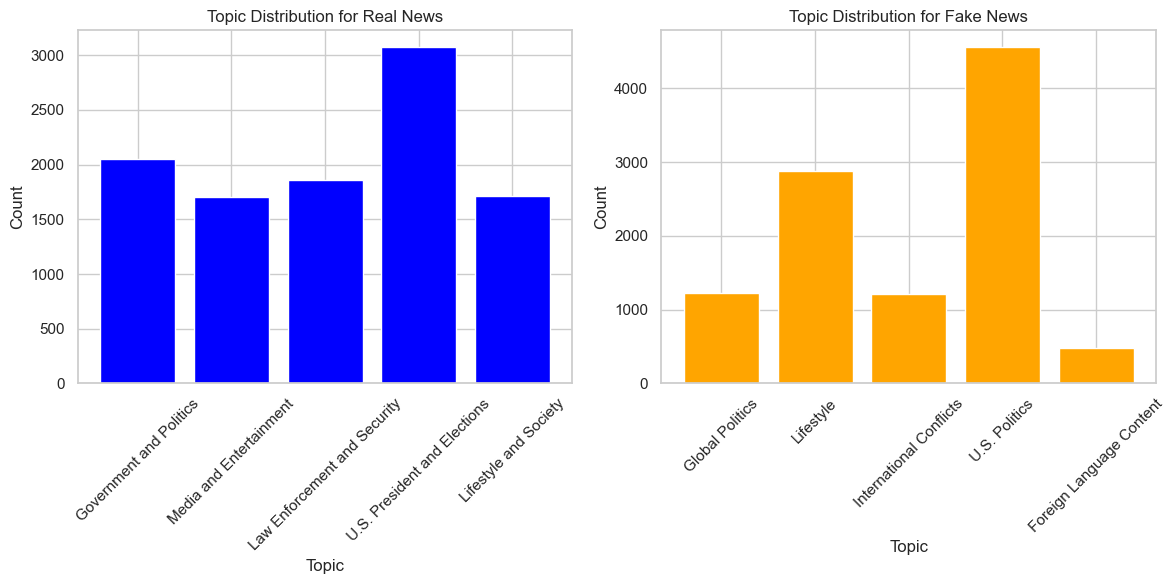

In [206]:
# Assign topics to real news
real_topic_assignments = [real_lda_model[doc] for doc in real_corpus]
real_topics = [max(doc, key=lambda x: x[1])[0] for doc in real_topic_assignments]

# Assign topics to fake news
fake_topic_assignments = [fake_lda_model[doc] for doc in fake_corpus]
fake_topics = [max(doc, key=lambda x: x[1])[0] for doc in fake_topic_assignments]

# Count the occurrences of each topic in real news
real_topic_counts = dict()
for topic in real_topics:
    real_topic_counts[topic] = real_topic_counts.get(topic, 0) + 1

# Count the occurrences of each topic in fake news
fake_topic_counts = dict()
for topic in fake_topics:
    fake_topic_counts[topic] = fake_topic_counts.get(topic, 0) + 1

# Define the topic labels for real news
real_topic_labels = {  
    0: 'Government and Politics',
    1: 'Media and Entertainment',
    2: 'Law Enforcement and Security',
    3: 'U.S. President and Elections',
    4: 'Lifestyle and Society'
}

# Define the topic labels for fake news
fake_topic_labels = {
    0: 'Global Politics',
    1: 'Lifestyle',
    2: 'International Conflicts',
    3: 'U.S. Politics',
    4: 'Foreign Language Content'
}

# Create a subplot with a 1x2 arrangement
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for real news topics
axs[0].bar(real_topic_counts.keys(), real_topic_counts.values(), color='blue')
axs[0].set_title('Topic Distribution for Real News')
axs[0].set_xlabel('Topic')
axs[0].set_ylabel('Count')
axs[0].set_xticks(list(real_topic_labels.keys()))
axs[0].set_xticklabels([real_topic_labels[topic] for topic in real_topic_labels], rotation=45)

# Bar plot for fake news topics
axs[1].bar(fake_topic_counts.keys(), fake_topic_counts.values(), color='orange')
axs[1].set_title('Topic Distribution for Fake News')
axs[1].set_xlabel('Topic')
axs[1].set_ylabel('Count')
axs[1].set_xticks(list(fake_topic_labels.keys()))
axs[1].set_xticklabels([fake_topic_labels[topic] for topic in fake_topic_labels], rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplot
plt.show()

## Hypothesis Testing

We conducted hypothesis testing, including Two-sample t-tests and Chi-square tests of independence, on the real and fake news datasets. The tests indicated a significant difference in the average word count and the frequency of common words between real and fake news. This confirms our initial analysis and underscores the potential importance of these attributes as features in our classification models.

### Two-Sample T-Test:
In the Two-Sample T-Test we can compare the average word count of fake news articles to that of real news articles to determine if there is a significant difference between them.

In [201]:
import numpy as np

# Calculate the variance of word_count for real news
real_var = np.var(real_news['word_count'])

# Calculate the variance of word_count for fake news
fake_var = np.var(fake_news['word_count'])

# Print the variances
print("Variance of word_count for real news:", real_var)
print("Variance of word_count for fake news:", fake_var)

Variance of word_count for real news: 105522.36264773176
Variance of word_count for fake news: 192701.63384757188


In [202]:
import scipy.stats as stats

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(real_news['word_count'], fake_news['word_count'], equal_var=False)

# Print the t-statistic and p-value
print("Two-Sample T-Test Results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


Two-Sample T-Test Results:
t-statistic: 19.284337946209142
p-value: 4.379345730440234e-82


**Inference** :
Since the p-value is significantly less than the commonly used significance level (e.g., 0.05), we can reject the null hypothesis. The null hypothesis in this case would be that there is no significant difference in the average word count between real news and fake news articles.

Therefore, we can infer that there is a significant difference in the average word count between real and fake news articles. The t-statistic of 19.3403785293225 suggests that the difference is substantial.

In summary, the results indicate that there is a statistically significant difference in the average word count between real and fake news articles.

### Chi-squared Test:

For performing Chi-squared test, lets find the common words between the real and fake news and test if there is any statistically significant association of the common words with the real vs fake labels

In [203]:
# Extract the common words and their counts
common_words = set(real_freq_dist.keys()).intersection(set(fake_freq_dist.keys()))

common_word_counts = {
    word: (real_freq_dist[word], fake_freq_dist[word])
    for word in common_words
}

# Create a DataFrame for the cross-tabulation table
cross_tab_data = {
    'Words': list(common_words),
    'Real': [count[0] for count in common_word_counts.values()],
    'Fake': [count[1] for count in common_word_counts.values()]
}
cross_tab_df = pd.DataFrame(cross_tab_data)

# Set the 'Words' column as the index
cross_tab_df.set_index('Words', inplace=True)

# Display the cross-tabulation table
print(cross_tab_df.T)

# Perform the Chi-Square Test of Independence
chi2_stat, p_value, _, _ = stats.chi2_contingency(cross_tab_df.T)
print("\nChi-Square Test of Independence Results:")
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_value)


Words  yarn  forecasters  formatting  protester  drafting  kurdish  mcmillan  \
Real      8           30           5         78        54      282         5   
Fake      2            3          43         92        17      266         1   

Words  focal  steve  ghanaian  ...  arrive  ladies  circ  catapulted  \
Real      22    613         3  ...     239      86     1          21   
Fake      22    227         2  ...     129      68     1           6   

Words  resonant  obliterating  centred  stopped  replenish  intensifies  
Real         22             7        1      857          8           11  
Fake          4            12        3      406         10            8  

[2 rows x 47918 columns]

Chi-Square Test of Independence Results:
Chi-Square Statistic: 676798.2756068403
p-value: 0.0


The cross-tabulation table shows the counts of common words for real and fake news articles. Each row represents a common word, and the columns 'Real' and 'Fake' display the respective counts of that word in the real and fake news datasets.

The Chi-Square Test of Independence results indicate a significant association between the presence of common words and the labels (real or fake) of the news articles. The chi-square statistic is calculated as 675,930.38, which represents the test statistic value. The p-value is calculated as 0.0, which is less than the commonly used significance level of 0.05.

The low p-value suggests strong evidence to reject the null hypothesis, indicating that the presence of common words is significantly associated with the labels (real or fake) of the news articles. In other words, the occurrence of these common words differs significantly between real and fake news.

Therefore, based on the Chi-Square Test of Independence, there is evidence to suggest that the presence of these specific words can be informative in distinguishing between real and fake news articles.

### Writing Train df to csv file 
Write the preprocessed train dataframe to a csv file for use at the subsequent modeling stage.

In [211]:
# Define the output file path
output_path = 'data/news/train_processed.csv'

# Write the train_df dataframe to a CSV file
train_df.to_csv(output_path, index=False)

print("Train dataframe saved to", output_path)

Train dataframe saved to data/news/train_processed.csv


In [207]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         20203 non-null  object
 1   text          20761 non-null  object
 2   label         20761 non-null  int64 
 3   news          20761 non-null  object
 4   clean         20761 non-null  object
 5   clean_joined  20761 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.6+ MB
